In [146]:
import numpy as np 
import pandas as pd
import os
import psycopg2
import geopandas as gpd

import importlib
from Secrets import secrets
# importlib.reload(secrets)

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import time

# Get Dataset 

In [262]:
# Get the summary of property and area characteristics, plus sold price
# However, the property price dataset is likely to include government schemes, shared owernship 
# Therefore exclude any property with very low sold price
# Assume the minimum property price is 200000
# Also filter out anything less than 15sqm or more than 300 as there may be mistake in epc data


engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    p.brn, p.year, p.lsoa, c.ward_name, e.number_habitable_rooms, 
    p.type, p.duration, p.new, e.construction_age_band, 
    e.potential_energy_rating, 
    sum_cases, avg_no_of_res, 
    CASE WHEN num_of_stations > 0 THEN 1 ELSE 0 END as num_of_stations, 
    CASE WHEN num_of_stores > 0 THEN 1 ELSE 0 END as num_of_stores, 
    num_of_schools, 
    CASE WHEN num_of_top_schools >0 THEN 1 ELSE 0 END as num_of_top_schools,
    
    ROUND( ((CAST(potential_energy_efficiency as float) - CAST(current_energy_efficiency as float) )/CAST(potential_energy_efficiency as float))::numeric, 1) as diff,
    CAST(ROUND((p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqm_price,
    e.total_floor_area,
    p.price
    
from prices as p
join epc as e
on e.brn = p.brn

join ( select c.year, c.lsoa, g.ward_name, sum(c.value) as sum_cases, avg(g.no_of_res) as avg_no_of_res
from crime_by_year as c
join geo2 as g
on g.lsoa = c.lsoa
where g.no_of_res != 0
group by 1, 2, 3) as c
on p.lsoa = c.lsoa and p.year = c.year

left join (select lsoa, count(station) as num_of_stations
from stations group by 1) as s
on s.lsoa = p.lsoa

left join (select lsoa, count(distinct name) as num_of_stores from stores group by 1) as st
on st.lsoa = p.lsoa


left join (select lsoa, count(distinct school_nam) as num_of_schools from schools2 group by 1) as sc
on sc.lsoa = p.lsoa

left join (select lsoa, count(distinct school_nam) as num_of_top_schools from schools2 where top_rated = 'Y' group by 1) as sc2
on sc2.lsoa = p.lsoa

where e.total_floor_area <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null and e.potential_energy_efficiency <>0
and p.price > 200000
and e.total_floor_area > 15 and e.total_floor_area < 300
and CAST(ROUND((p.price/e.total_floor_area)::numeric, 3 ) as integer) > 1000 and CAST(ROUND((p.price/e.total_floor_area)::numeric, 3 ) as integer) < 16000
;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result = result.fillna(0)
result["diff"] = result["diff"].astype('float')
print(result.shape)
result.head()

(1098261, 20)


,brn,year,lsoa,ward_name,number_habitable_rooms,type,duration,new,construction_age_band,potential_energy_rating,sum_cases,avg_no_of_res,num_of_stations,num_of_stores,num_of_schools,num_of_top_schools,diff,sqm_price,total_floor_area,price
0,4.552979e+09,2008.0,E01000006,Abbey,5.0,T,F,N,1900-1929,B,104.0,1703.0,0,0,14.0,0,0.3,2632,95.000,249995.0
1,1.075111e+09,2009.0,E01000006,Abbey,5.0,T,F,N,1900-1929,C,91.0,1703.0,0,0,14.0,0,0.3,1869,130.000,243000.0
2,9.017893e+09,2009.0,E01000006,Abbey,4.0,T,F,N,1930-1949,G,91.0,1703.0,0,0,14.0,0,0.1,3497,65.780,230000.0
3,3.839129e+09,2009.0,E01000006,Abbey,4.0,T,F,N,1930-1949,C,91.0,1703.0,0,0,14.0,0,0.2,2534,86.816,220000.0
4,9.017893e+09,2009.0,E01000006,Abbey,5.0,T,F,N,1930-1949,B,91.0,1703.0,0,0,14.0,0,0.2,2644,87.000,230000.0


# Segment the areas based on type of Food/Bars there are


In [263]:
# Extract a few of the moost popular food venue categories
# Look at venue count per resident?
#
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    lsoa,
    sum(CASE WHEN l3 in ('Café', 'Coffee Shop') THEN 1 else 0 end) as count_coffee_shop,
    sum(CASE WHEN l3 in ('Pub') THEN 1 else 0 end) as count_pub,
    sum(CASE WHEN l3 in ('Bar') THEN 1 else 0 end) as count_bar,
    sum(CASE WHEN l3 in ('Cocktail Bar') THEN 1 else 0 end) as count_cocktail,
    sum(CASE WHEN l3 in ('French Restaurant', 'Japanese Restaurant') THEN 1 else 0 end) as count_french_japan,
    sum(CASE WHEN l3 in ('Indian Restaurant', 'Chinese Restaurant') THEN 1 else 0 end) as count_asian 
    
    from food
    group by 1
;

""")
rows = cur.fetchall()
df_food = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
print(df_food.shape)
df_food.dropna(inplace=True)
df_food.head()

(4833, 7)


,lsoa,count_coffee_shop,count_pub,count_bar,count_cocktail,count_french_japan,count_asian
0,E01002168,3,2,1,1,0,16
1,E01001262,4,2,1,1,0,9
2,E01002671,13,9,1,0,5,5
3,E01001641,10,14,0,0,4,1
4,E01004374,13,5,2,0,0,4


In [220]:
# Normalize the data
df_food_norm = df_food[df_food.columns[1:]].div(df_food[df_food.columns[1:]].sum(axis=1), axis=0)
df_food_norm.fillna(0, inplace=True)

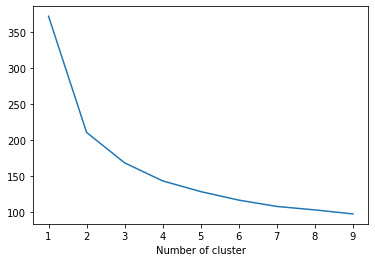

In [221]:
# Use elbow method to find an optimal number of K
from sklearn.cluster import KMeans

sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_food_norm)
    df_food_norm["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [222]:
# Looks like there are about 3 clusters
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(df_food_norm)
df_food_norm["clusters"] = kmeans.labels_
df_food_norm["lsoa"] = df_food["lsoa"]

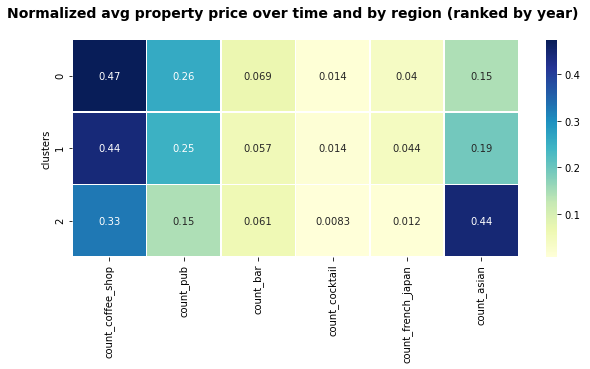

In [235]:
# examine clusters
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(df_food_norm.groupby("clusters").mean(), annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")
ax.set_title("Normalized avg property price over time and by region (ranked by year) \n", fontweight='bold', fontsize=14)
plt.show()

In [ ]:
# Unnormalized version

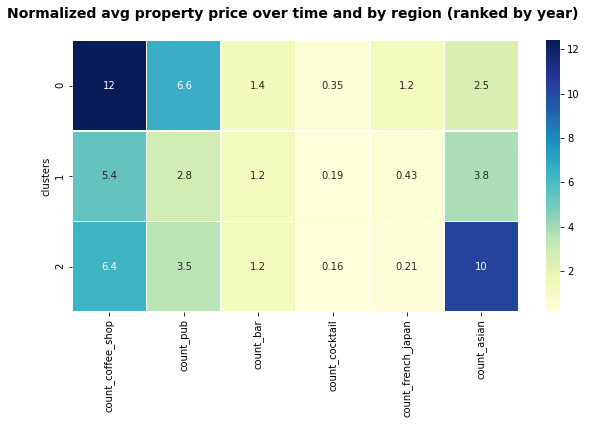

In [233]:
# Use elbow method to find an optimal number of K
from sklearn.cluster import KMeans
df = df_food[df_food.columns[1:]]
# Looks like there are about 4 clusters
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(df)
df["clusters"] = kmeans.labels_
df["lsoa"] = df_food["lsoa"]

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(df.groupby("clusters").mean(), annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")
ax.set_title("Normalized avg property price over time and by region (ranked by year) \n", fontweight='bold', fontsize=14)
plt.show()

In [264]:
# Quick check back to the price per sqm
df_temp = result.merge(df_food_norm, how="right", on="lsoa")[["clusters", "sqm_price", "total_floor_area", "price"]]
df_temp.groupby("clusters").agg({"sqm_price": ["mean", "std", "min", "max"], "total_floor_area": ["mean", "std", "min", "max"], "price": "mean"})

sqm_price                               total_floor_area  \
                 mean          std     min      max             mean   
clusters                                                               
0         5822.466140  2478.704076  1016.0  15999.0        88.999578   
1         6161.027809  2949.308769  1005.0  15998.0        89.694073   
2         4441.911969  1541.094828  1009.0  15952.0        93.432146   

                                           price  
                std    min    max           mean  
clusters                                          
0         45.264031  15.37  896.0  507969.693346  
1         47.086092  15.25  899.0  541555.210110  
2         39.441031  15.10  784.0  402372.059369

In [ ]:
# Interesting observation:
# Cluster 1 tend to have more coffee shops less indian/chinese restaurants, more pubs and bars, coctail places
# Cluster 2 tend to have more a bit of all venues
# Cluster 3 tend to have more indian/chinese restaurants than other clusters
# From the price perspective:
# Cluster 2 has the lowest price indicating that potentially indian/chinese restaurants are located in outskirts in more affordable areas and larger houses
# Cluster 0 is more expensive than cluster 2 potentially driven by more venues to go out
# Cluster 1 is the most expensive potentially a high end suburbs area

In [265]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
select
    lsoa, rg_name, lsoa_geometry from geo2
"""

gdf_new = gpd.read_postgis(sql, engine, geom_col='lsoa_geometry') 
gdf_new.head(2)

,lsoa,rg_name,lsoa_geometry
0,E01000001,City of London,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000007,Barking and Dagenham,"POLYGON ((544180.347 184700.582, 544317.196 18..."


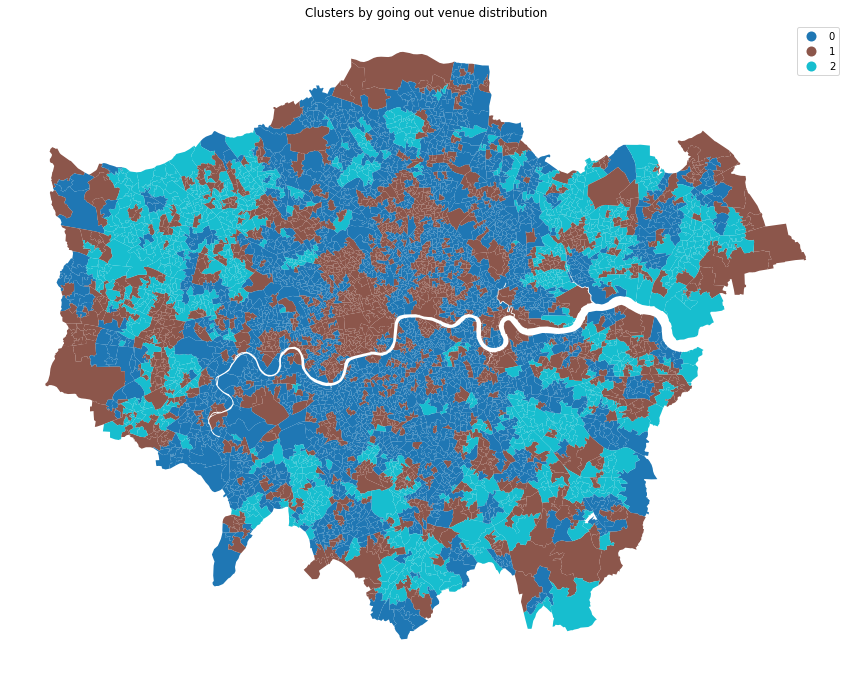

In [326]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.axis('off')
temp = gdf_new.merge(df_food_norm, how="right", on="lsoa")
temp["clusters"] = temp["clusters"].astype("str")
temp.plot(ax = ax, column="clusters",legend=True)
ax.set_title("Clusters by going out venue distribution")
plt.show()

# This shows a great result
# Cluster 1 (the most expensive) is focused on central parts of each borough
# Cluster 0 the 2nd most expensive is surrunding the borough centers
# Cluster 2 is more remote to any central part of any borough

#  Segment areas based on the price distribution

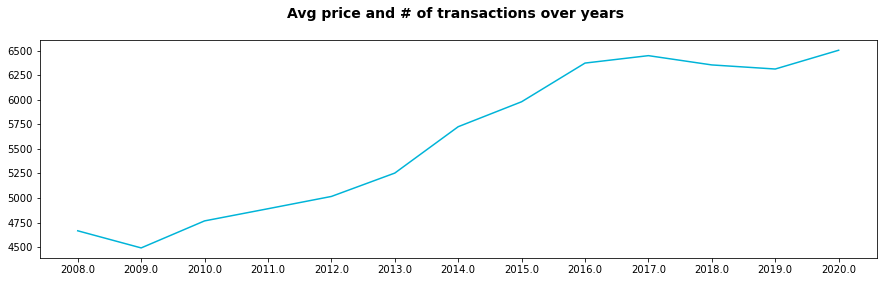

In [276]:
# Agree on the period
# If we want to forecast the current property price (say for the next 6 months) we can use the current year prices as a base
# Train period is 2017-2019-2020 (as per below) average price per sqm is marginanly unchanged during those years

fig, ax = plt.subplots(figsize=(15, 4))
labels = result.groupby("year", as_index=False)["sqm_price"].mean()["year"].values
ax.set_title("Avg price and # of transactions over years \n", fontweight='bold', fontsize=14)
ax.plot(result.groupby("year", as_index=False)["sqm_price"].mean()["sqm_price"], color="#00b4d8")
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

plt.show()

In [294]:
df_subset.groupby("lsoa", as_index=False).agg( {"sqm_price": ["mean", "std"]})

lsoa    sqm_price             
                        mean          std
0     E01000006  4229.636364   789.321705
1     E01000007  4375.333333   608.636292
2     E01000008  3596.208333   560.209121
3     E01000009  3834.640000   756.711739
4     E01000010  5139.470000  1158.742243
...         ...          ...          ...
4823  E01033742  4805.200000   618.992114
4824  E01033743  4200.571429   718.537273
4825  E01033744  5012.683333   807.205947
4826  E01033745  4243.266667   686.073694
4827  E01033746  8741.477477  1889.605865

[4828 rows x 3 columns]

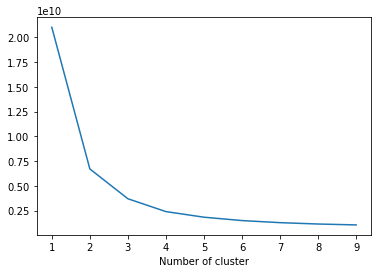

In [311]:
df_subset = result[result.year > 2016]
df_subset = df_subset.groupby("lsoa", as_index=False).agg( {"sqm_price": ["mean", "std", "count"]})
df_subset.columns =["lsoa", "mean", "std", "count"]
df_subset.fillna(df_subset["std"].mean(), inplace=True)
# Use elbow method to find an optimal number of K
from sklearn.cluster import KMeans

df_temp = df_subset[df_subset.columns[1:]]
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_temp)
    df_temp["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [314]:
# Looks like there are about 3 clusters
df_temp = df_subset[df_subset.columns[1:]]
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(df_temp)
df_temp["clusters"] = kmeans.labels_
df_temp["lsoa"] = df_subset["lsoa"]

In [318]:
df_temp.groupby("clusters").agg({"lsoa": "count", "mean":"mean", "std":"mean", "count": "mean"}).rename({"lsoa": "no_of_lsoa"})

,lsoa,mean,std,count
clusters,,,,
0,2628,4981.326512,1061.802208,64.451294
1,1534,7202.130678,1746.425836,67.399609
2,666,10253.945651,2409.402323,61.687688


In [319]:
# This is very insightful
# Cluster 0 > has mohast lsoa areas, lowest mean price per sqm of 5k, lowest std of mean price
# Cluster 1 > has less lsoa areas, much higher average price per sqm, higher std
# Cluster 3 > lsoa with the most expensive property, and the most variance in mean price
# All clusters include lsoa areas with average of 60 sold property so the view is balanced
# There seem to be a negative relationship between price per sqm and variance of the price
# The more expensive is the area the more variation in the price

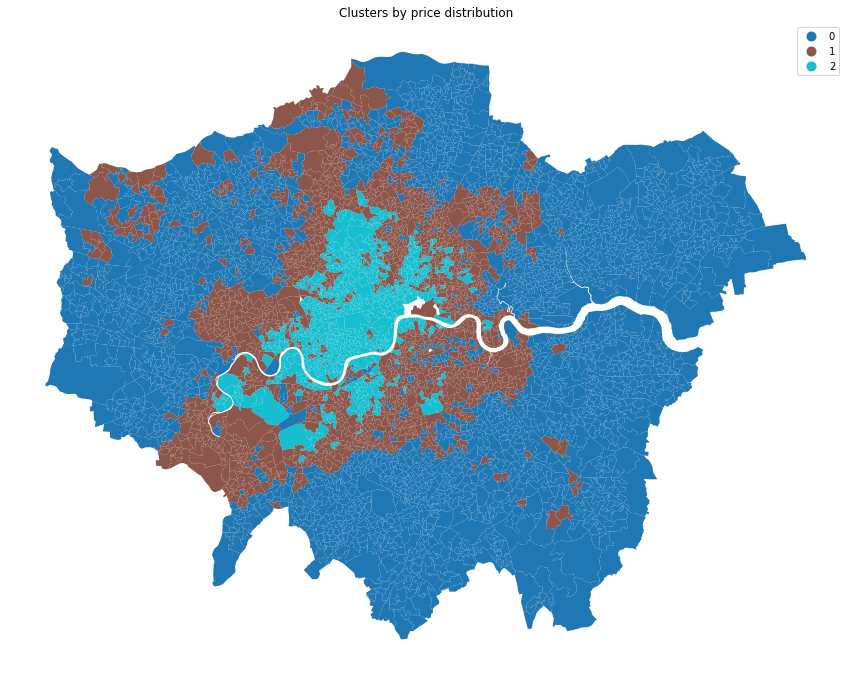

In [325]:
ig, ax = plt.subplots(figsize=(15, 15))
ax.axis('off')
temp = gdf_new.merge(df_temp, how="right", on="lsoa")
temp["clusters"] = temp["clusters"].astype("str")
temp.plot(ax = ax, column="clusters",legend=True)
ax.set_title("Clusters by price distribution")
plt.show()

# Combine dataset for predictive model

In [342]:
df = result[['lsoa', 'number_habitable_rooms', 'type',
       'duration', 'new', 'construction_age_band', 'potential_energy_rating',
       'sum_cases', 'avg_no_of_res', 'num_of_stations', 'num_of_stores',
       'num_of_schools', 'num_of_top_schools', 'diff', 'sqm_price',
       'total_floor_area']]

# add venue clusters
df = df.merge(df_food_norm[["clusters", "lsoa"]].rename(columns = {"clusters": "venue_clusters"}), on="lsoa")

# add price clusters (use instead of area)
df = df.merge(df_temp[["clusters", "lsoa"]].rename(columns = { "clusters": "price_clusters"}), on="lsoa")

# drop lsoa
df.drop("lsoa", axis=1, inplace=True)
# Random Forest + mean encoding
# Cluster areas based on price etc


# Mean Encoding (Average from the entire dataset)

In [343]:
df['type'] = df.groupby(['type', 'price_clusters'])['sqm_price'].transform('mean')
df['duration'] = df.groupby(['duration', 'price_clusters'])['sqm_price'].transform('mean')
df['new'] = df.groupby(['new', 'price_clusters'])['sqm_price'].transform('mean')
df['construction_age_band'] = df.groupby(['construction_age_band', 'price_clusters'])['sqm_price'].transform('mean')
df['potential_energy_rating'] = df.groupby(['potential_energy_rating', 'price_clusters'])['sqm_price'].transform('mean')

In [344]:
df

,number_habitable_rooms,type,duration,new,construction_age_band,potential_energy_rating,sum_cases,avg_no_of_res,num_of_stations,num_of_stores,num_of_schools,num_of_top_schools,diff,sqm_price,total_floor_area,venue_clusters,price_clusters
0,5.0,4027.721779,4107.451889,4238.717467,4217.601287,4281.866179,104.0,1703.0,0,0,14.0,0,0.3,2632,95.000,0,0
1,5.0,4027.721779,4107.451889,4238.717467,4217.601287,4305.530027,91.0,1703.0,0,0,14.0,0,0.3,1869,130.000,0,0
2,4.0,4027.721779,4107.451889,4238.717467,4189.232606,3948.644528,91.0,1703.0,0,0,14.0,0,0.1,3497,65.780,0,0
3,4.0,4027.721779,4107.451889,4238.717467,4189.232606,4305.530027,91.0,1703.0,0,0,14.0,0,0.2,2534,86.816,0,0
4,5.0,4027.721779,4107.451889,4238.717467,4189.232606,4281.866179,91.0,1703.0,0,0,14.0,0,0.2,2644,87.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097794,7.0,5893.860947,5921.201869,6015.775958,6410.785798,5912.638496,61.0,1464.0,0,0,5.0,0,0.2,7799,143.600,1,1
1097795,8.0,5893.860947,5921.201869,6015.775958,6410.785798,6070.554740,61.0,1464.0,0,0,5.0,0,0.4,9322,177.000,1,1
1097796,9.0,5893.860947,5921.201869,6015.775958,6136.181541,6070.554740,61.0,1464.0,0,0,5.0,0,0.3,8088,204.000,1,1
1097797,5.0,5893.860947,5921.201869,6015.775958,6410.785798,6070.554740,61.0,1464.0,0,0,5.0,0,0.3,8763,97.000,1,1


In [348]:
X = df.drop("sqm_price", axis=1)
y = df["sqm_price"]

In [347]:

# Run Regression on a random sample as otherwise the dataset is too large
# df_sample = result.sample(n=1000000, replace=False, random_state=5)
X = df.drop("sqm_price", axis=1)
y = df["sqm_price"]
# Run reg on all feature
reg_x = " + ".join(X.columns)

# Fit regression model (using the natural log of one of the regressors)
reg_result = smf.ols(f'sqm_price ~ {reg_x}', data=df).fit()

# Inspect the results
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:              sqm_price   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 5.179e+04
Date:                Fri, 29 Jan 2021   Prob (F-statistic):               0.00
Time:                        11:47:18   Log-Likelihood:            -9.8512e+06
No. Observations:             1097799   AIC:                         1.970e+07
Df Residuals:                 1097781   BIC:                         1.970e+07
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -9

In [ ]:
# All features are found to be statistically significant, however R2 is only 15% which may indicate that the relationship is not linear

In [360]:
X["sum_cases"] = np.log(X["sum_cases"])
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

/home/elena/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Random Forest

In [ ]:

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

regr = RandomForestRegressor(n_estimators = 5, random_state=0)
regr.fit(X_train, y_train)
df_features = pd.DataFrame(np.stack([X.columns.values, regr.feature_importances_], axis=1), columns=["Feature", "Rank"]).sort_values(by="Rank", ascending=False)
train_score = regr.score(X_train, y_train)
test_score = regr.score(X_test, y_test)

print("test ", test_score)
print("train ", train_score)

In [ ]:
df_features

In [151]:
my_dict = {"n_est": [], "n_depth": [], "train_score": [], "test_score": [], "time_taken": []}

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

n_est = [50, 100, 200]
n_depth = [5, 10, 20]
for i in n_est:
    for j in n_depth:
        # Start the clock to capture how long the model takes to run
        start_time = time.time()
        
        regr = RandomForestRegressor(n_estimators = i, max_depth=j, random_state=0)
        regr.fit(X_train, y_train)
        train_score = regr.score(X_train, y_train)
        test_score = regr.score(X_test, y_test)
        
        time_taken = time.time() - start_time
        
        # Collect stats
        my_dict["n_est"].append(i)
        my_dict["n_depth"].append(j)
        my_dict["train_score"].append(train_score)
        my_dict["test_score"].append(test_score)
        my_dict["time_taken"].append(time_taken)
        
forest_results = pd.DataFrame(my_dict) 

In [152]:
forest_results

,n_est,n_depth,train_score,test_score,time_taken
0,50,5,0.337910,0.290715,120.294073
1,50,10,0.714870,0.378346,214.538842
2,50,20,0.872825,0.379353,344.578586
3,100,5,0.336035,0.279454,626.214745
4,100,10,0.714132,0.376326,422.831107
5,100,20,0.869614,0.382623,1124.383540
6,200,5,0.340545,0.273081,358.575834
7,200,10,0.714023,0.375659,620.687309
8,200,20,0.871861,0.379786,1014.640726
